<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Nalinda/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Bidirectional, BatchNormalization

# reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [14]:
# Clean Train/Test Data Loading from Google Drive
import pandas as pd
import os

# Paths to your files
train_path = "/content/drive/MyDrive/DiabetesPrediction/outputs/train.csv"
test_path  = "/content/drive/MyDrive/DiabetesPrediction/outputs/test.csv"

# Check file existence before loading
for path in [train_path, test_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ File not found: {path}\nPlease verify the path in Google Drive.")

# Load CSV files
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# ✅ Basic dataset info
print("✅ Train shape:", train_df.shape)
print("✅ Test shape:",  test_df.shape)

# Check class balance (assuming 'diabetes' is your target)
target_col = 'diabetes'
if target_col in train_df.columns:
    class_dist = train_df[target_col].value_counts(normalize=True)
    print(f"\n⚖️ Class distribution in train set:\n{class_dist}")

# Preview only first 5 rows
print("\n📘 Sample records:")
display(train_df.head())

print("\n✅ Train and Test datasets successfully loaded from Google Drive!")


✅ Train shape: (140262, 9)
✅ Test shape: (35066, 9)

⚖️ Class distribution in train set:
diabetes
1    0.5
0    0.5
Name: proportion, dtype: float64

📘 Sample records:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1.183769,1.693635,3.447677,4.848534,0.408968,0.761924,2.496579,0.054263,1
1,1.183769,0.308435,-0.290050,-0.206248,-1.186816,0.055526,1.373995,0.047584,1
2,-0.843459,-1.014757,-0.290050,-0.206248,-1.186816,0.006561,-0.684077,0.518038,0
3,-0.843459,0.945914,-0.290050,-0.206248,0.940896,0.094711,3.057872,3.514083,1
4,-0.843459,0.358859,-0.290050,-0.206248,0.940896,2.832448,0.438507,-0.129164,1



✅ Train and Test datasets successfully loaded from Google Drive!


In [15]:
#  Split features and target
target_col = 'diabetes'  # change if your column name is different

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values
X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col].values

print("Features:", X_train.shape[1], " Target distribution:", np.bincount(y_train))


Features: 8  Target distribution: [70131 70131]


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [18]:
#  Reshape for LSTM (each feature = timestep)
X_train_seq = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_seq  = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("Train seq shape:", X_train_seq.shape)


Train seq shape: (140262, 8, 1)


In [20]:
# Define advanced LSTM model
def build_lstm(input_shape):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4)))(inp)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(32))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

model = build_lstm((X_train_seq.shape[1], 1))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 8, 128)         │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 8, 128)         │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,633 (303.25 KB)

 Trainable params: 77,505 (302.75 KB)

 Non-trainable params: 128 (512.00 B)

In [21]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, mode='max')
checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/DiabetesPrediction/best_lstm.h5', save_best_only=True, monitor='val_auc', mode='max')


In [22]:
#  Train model
history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_1,loss,val_accuracy,val_auc_1,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_1,loss,val_accuracy,val_auc_1,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


3507/3507 - 49s - 14ms/step - accuracy: 0.8907 - auc_1: 0.9655 - loss: 0.2379 - val_accuracy: 0.9041 - val_auc_1: 0.9751 - val_loss: 0.1991 - learning_rate: 1.0000e-03
Epoch 2/20


3507/3507 - 82s - 23ms/step - accuracy: 0.9031 - auc_1: 0.9736 - loss: 0.2050 - val_accuracy: 0.9106 - val_auc_1: 0.9777 - val_loss: 0.1871 - learning_rate: 1.0000e-03
Epoch 3/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9057 - auc_1: 0.9753 - loss: 0.1974 - val_accuracy: 0.9112 - val_auc_1: 0.9783 - val_loss: 0.1844 - learning_rate: 1.0000e-03
Epoch 4/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9069 - auc_1: 0.9757 - loss: 0.1953 - val_accuracy: 0.9120 - val_auc_1: 0.9787 - val_loss: 0.1827 - learning_rate: 1.0000e-03
Epoch 5/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9082 - auc_1: 0.9763 - loss: 0.1926 - val_accuracy: 0.9115 - val_auc_1: 0.9787 - val_loss: 0.1832 - learning_rate: 1.0000e-03
Epoch 6/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9093 - auc_1: 0.9768 - loss: 0.1902 - val_accuracy: 0.9101 - val_auc_1: 0.9781 - val_loss: 0.1863 - learning_rate: 1.0000e-03
Epoch 7/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9088 - auc_1: 0.9768 - loss: 0.1898 - val_accuracy: 0.9113 - val_auc_1: 0.9786 - val_loss: 0.1819 - learning_rate: 1.0000e-03
Epoch 8/20


3507/3507 - 42s - 12ms/step - accuracy: 0.9098 - auc_1: 0.9773 - loss: 0.1877 - val_accuracy: 0.9110 - val_auc_1: 0.9789 - val_loss: 0.1812 - learning_rate: 1.0000e-03
Epoch 9/20


3507/3507 - 44s - 13ms/step - accuracy: 0.9096 - auc_1: 0.9773 - loss: 0.1876 - val_accuracy: 0.9118 - val_auc_1: 0.9791 - val_loss: 0.1802 - learning_rate: 1.0000e-03
Epoch 10/20


3507/3507 - 42s - 12ms/step - accuracy: 0.9104 - auc_1: 0.9778 - loss: 0.1858 - val_accuracy: 0.9122 - val_auc_1: 0.9792 - val_loss: 0.1794 - learning_rate: 1.0000e-03
Epoch 11/20


3507/3507 - 82s - 23ms/step - accuracy: 0.9106 - auc_1: 0.9778 - loss: 0.1852 - val_accuracy: 0.9113 - val_auc_1: 0.9788 - val_loss: 0.1818 - learning_rate: 1.0000e-03
Epoch 12/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9114 - auc_1: 0.9780 - loss: 0.1844 - val_accuracy: 0.9144 - val_auc_1: 0.9801 - val_loss: 0.1757 - learning_rate: 1.0000e-03
Epoch 13/20


3507/3507 - 82s - 23ms/step - accuracy: 0.9112 - auc_1: 0.9782 - loss: 0.1837 - val_accuracy: 0.9125 - val_auc_1: 0.9793 - val_loss: 0.1799 - learning_rate: 1.0000e-03
Epoch 14/20


3507/3507 - 82s - 23ms/step - accuracy: 0.9115 - auc_1: 0.9783 - loss: 0.1835 - val_accuracy: 0.9134 - val_auc_1: 0.9801 - val_loss: 0.1762 - learning_rate: 1.0000e-03
Epoch 15/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9131 - auc_1: 0.9787 - loss: 0.1816 - val_accuracy: 0.9156 - val_auc_1: 0.9805 - val_loss: 0.1737 - learning_rate: 1.0000e-03
Epoch 16/20


3507/3507 - 44s - 13ms/step - accuracy: 0.9132 - auc_1: 0.9788 - loss: 0.1815 - val_accuracy: 0.9151 - val_auc_1: 0.9805 - val_loss: 0.1748 - learning_rate: 1.0000e-03
Epoch 17/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9136 - auc_1: 0.9791 - loss: 0.1800 - val_accuracy: 0.9150 - val_auc_1: 0.9804 - val_loss: 0.1746 - learning_rate: 1.0000e-03
Epoch 18/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9141 - auc_1: 0.9794 - loss: 0.1792 - val_accuracy: 0.9154 - val_auc_1: 0.9805 - val_loss: 0.1737 - learning_rate: 1.0000e-03
Epoch 19/20


3507/3507 - 43s - 12ms/step - accuracy: 0.9139 - auc_1: 0.9793 - loss: 0.1794 - val_accuracy: 0.9122 - val_auc_1: 0.9790 - val_loss: 0.1809 - learning_rate: 1.0000e-03
Epoch 20/20


3507/3507 - 44s - 12ms/step - accuracy: 0.9147 - auc_1: 0.9796 - loss: 0.1782 - val_accuracy: 0.9143 - val_auc_1: 0.9797 - val_loss: 0.1777 - learning_rate: 1.0000e-03


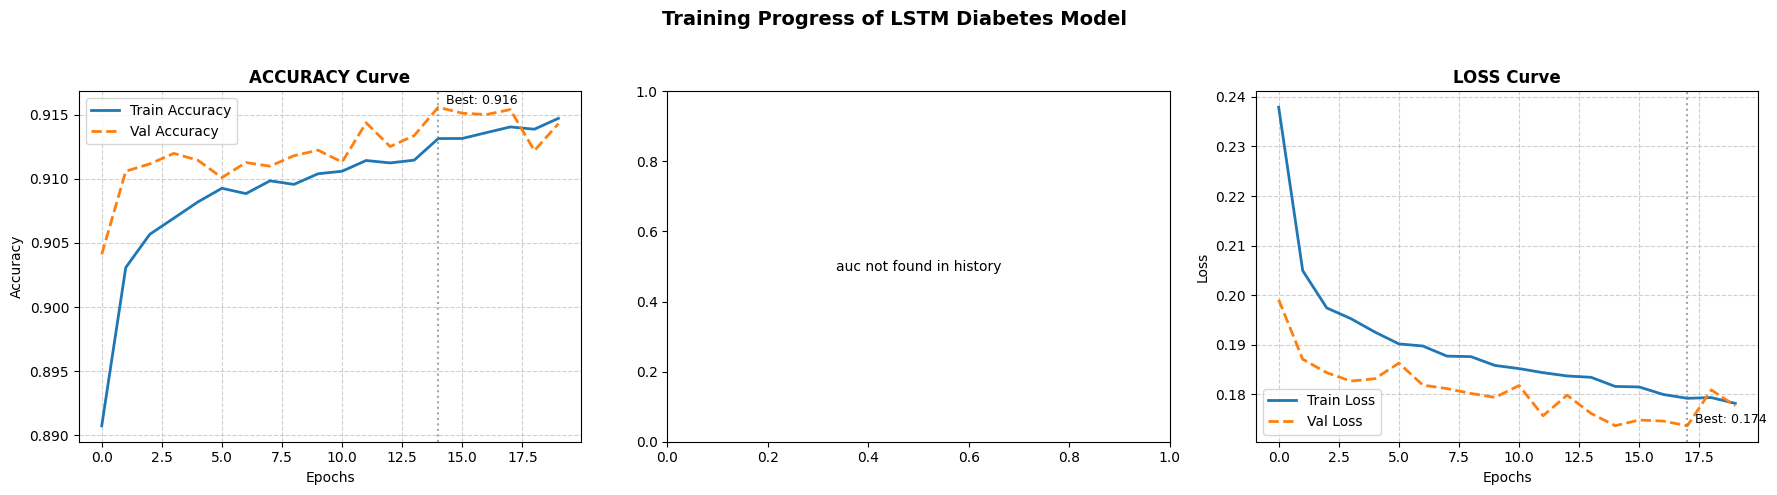

✅ Training plots saved at: /content/drive/MyDrive/DL_Project/plots/training_curves.png


In [23]:
#  Advanced Training Visualization

import matplotlib.pyplot as plt
import numpy as np
import os

# Create a save path (optional)
save_dir = "/content/drive/MyDrive/DL_Project/plots"
os.makedirs(save_dir, exist_ok=True)

# Helper function to plot any metric
def plot_metric(metric_name, history, ax):
    train_metric = history.history.get(metric_name)
    val_metric = history.history.get(f'val_{metric_name}')

    if train_metric and val_metric:
        ax.plot(train_metric, label=f'Train {metric_name.capitalize()}', linewidth=2)
        ax.plot(val_metric, label=f'Val {metric_name.capitalize()}', linewidth=2, linestyle='--')
        ax.set_title(f'{metric_name.upper()} Curve', fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_name.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        # Annotate best validation metric
        best_epoch = np.argmax(val_metric) if metric_name != 'loss' else np.argmin(val_metric)
        ax.axvline(best_epoch, color='gray', linestyle=':', alpha=0.7)
        ax.text(best_epoch, val_metric[best_epoch], f'  Best: {val_metric[best_epoch]:.3f}',
                color='black', fontsize=9, verticalalignment='bottom')
    else:
        ax.text(0.5, 0.5, f"{metric_name} not found in history",
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Accuracy, AUC, and Loss
plot_metric('accuracy', history, axs[0])
plot_metric('auc', history, axs[1])
plot_metric('loss', history, axs[2])

plt.suptitle('Training Progress of LSTM Diabetes Model', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Optionally save the figure
fig.savefig(os.path.join(save_dir, "training_curves.png"), dpi=300)
print(f"✅ Training plots saved at: {os.path.join(save_dir, 'training_curves.png')}")


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
===== Classification Report =====
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     17533
           1       0.89      0.93      0.91     17533

    accuracy                           0.91     35066
   macro avg       0.91      0.91      0.91     35066
weighted avg       0.91      0.91      0.91     35066

✅ Accuracy:  0.9116
✅ Precision: 0.8935
✅ Recall:    0.9346
✅ F1-Score:  0.9136
✅ AUC:       0.9789


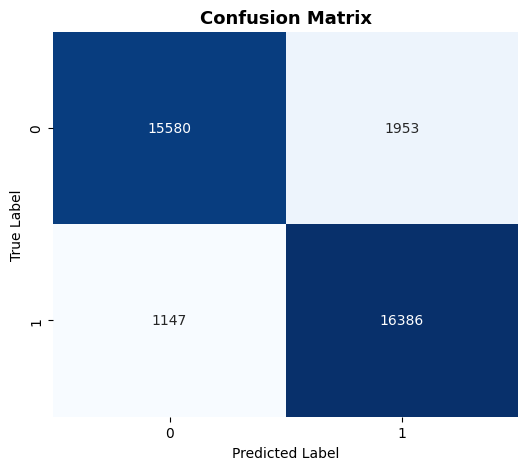

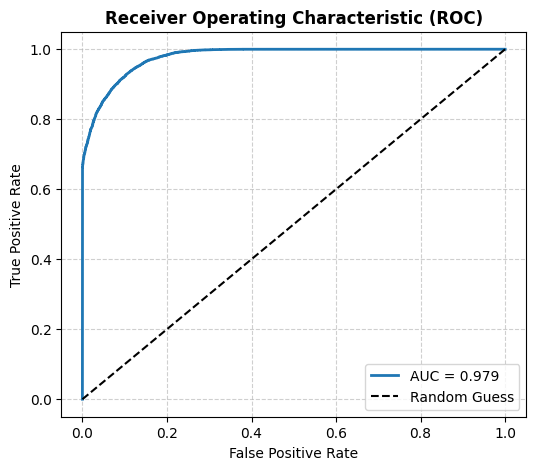

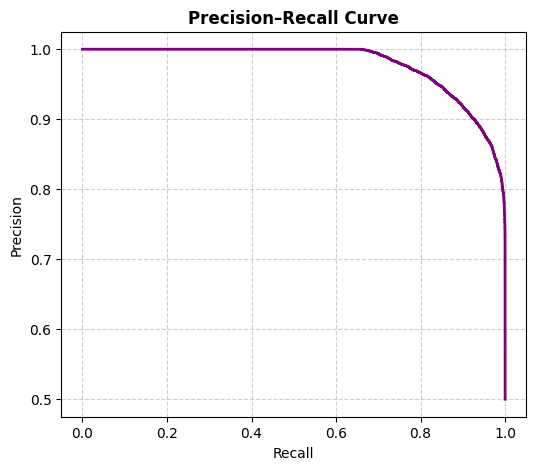


===== Sample Diabetes Predictions =====


,True_Label,Predicted_Label,Predicted_Probability
0,Non-Diabetic,Non-Diabetic,0.000
1,Non-Diabetic,Non-Diabetic,0.000
2,Diabetic,Diabetic,1.000
3,Non-Diabetic,Non-Diabetic,0.000
4,Diabetic,Diabetic,1.000
5,Non-Diabetic,Non-Diabetic,0.000
6,Diabetic,Diabetic,0.764
7,Diabetic,Diabetic,0.730
8,Non-Diabetic,Non-Diabetic,0.000
9,Non-Diabetic,Diabetic,0.743


✅ Prediction results saved at: /content/drive/MyDrive/DL_Project/plots/diabetes_predictions.csv

✅ Evaluation plots and prediction results saved successfully!


In [24]:
# Advanced Model Evaluation + Display Diabetes Results
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
import pandas as pd
import numpy as np
import os

# Make predictions
y_prob = model.predict(X_test_seq).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# 📊 Compute Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print("===== Classification Report =====")
print(classification_report(y_test, y_pred))
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1-Score:  {f1:.4f}")
print(f"✅ AUC:       {auc:.4f}")

# 📁 Save directory for plots
save_dir = "/content/drive/MyDrive/DL_Project/plots"
os.makedirs(save_dir, exist_ok=True)

# 🎯 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), dpi=300)
plt.show()

# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(os.path.join(save_dir, "roc_curve.png"), dpi=300)
plt.show()

# 📉 Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(os.path.join(save_dir, "precision_recall_curve.png"), dpi=300)
plt.show()

# ✅ Display actual prediction results
print("\n===== Sample Diabetes Predictions =====")

# Combine true & predicted labels in a DataFrame for easy viewing
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred,
    'Predicted_Probability': np.round(y_prob, 3)
})

# Map 0→Non-Diabetic, 1→Diabetic
results_df['True_Label'] = results_df['True_Label'].map({0: 'Non-Diabetic', 1: 'Diabetic'})
results_df['Predicted_Label'] = results_df['Predicted_Label'].map({0: 'Non-Diabetic', 1: 'Diabetic'})

# Show first 20 predictions for inspection
display(results_df.head(20))

# Optionally save full predictions to Drive
results_path = os.path.join(save_dir, "diabetes_predictions.csv")
results_df.to_csv(results_path, index=False)
print(f"✅ Prediction results saved at: {results_path}")

print("\n✅ Evaluation plots and prediction results saved successfully!")


In [ ]:
# Save final model
model.save("/content/drive/MyDrive/DiabetesPrediction/final_LSTM_model.h5")
print("Model saved to Drive ✅")
